In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,matthews_corrcoef
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV



In [19]:
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [20]:
df['Age'].value_counts()

Age
9.0     33244
10.0    32194
8.0     30832
7.0     26314
11.0    23533
6.0     19819
13.0    17363
5.0     16157
12.0    15980
4.0     13823
3.0     11123
2.0      7598
1.0      5700
Name: count, dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [22]:
df['Diabetes_binary'] = df['Diabetes_012'].apply(lambda x: 0 if x == 0 else 1)

In [23]:
df['Diabetes_binary'].value_counts(normalize=True)

Diabetes_binary
0    0.842412
1    0.157588
Name: proportion, dtype: float64

In [24]:
X = df.drop(columns=["Diabetes_012", "Diabetes_binary"])
y = df["Diabetes_binary"]

In [25]:
# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# Output shapes
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Training labels distribution:\n", y_train.value_counts(normalize=True))
print("Test labels distribution:\n", y_test.value_counts(normalize=True))

Training features shape: (202944, 21)
Test features shape: (50736, 21)
Training labels distribution:
 Diabetes_binary
0    0.84241
1    0.15759
Name: proportion, dtype: float64
Test labels distribution:
 Diabetes_binary
0    0.84242
1    0.15758
Name: proportion, dtype: float64


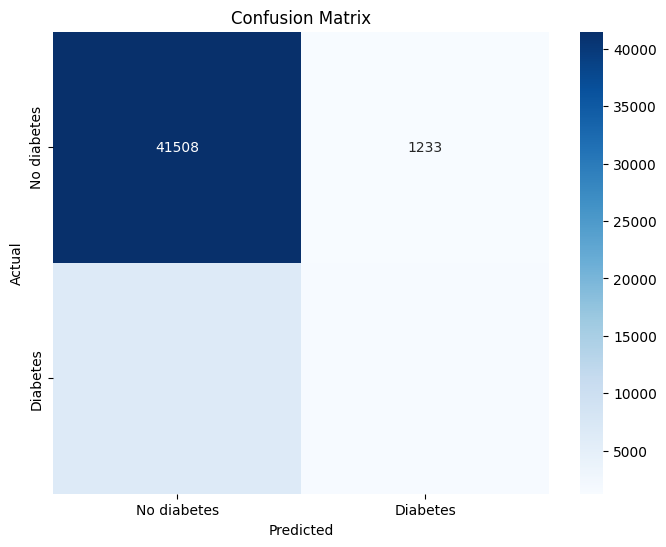

{'C': 93.85537090157501, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.1819249672071006}
MCC: 0.2598522523688184
accuracy: 0.8481354462314727
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     42741
           1       0.55      0.19      0.28      7995

    accuracy                           0.85     50736
   macro avg       0.71      0.58      0.60     50736
weighted avg       0.82      0.85      0.82     50736



In [34]:
param_dist = {
    'C': uniform(0.0001, 100),  # Continuous distribution from 0.0001 to 100
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
    'tol': uniform(0.0001, 1),  # tol from 0.0001 to 1
    'max_iter': [10000]
}

random_search = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=param_dist,
    n_iter=20,  # Try only 20 combinations
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1  # Run in parallel
)

random_search.fit(X_train, y_train)
best_params1 = random_search.best_params_

# Building the Logistic Regression model with the best parameters
model = LogisticRegression(**best_params1)
model.fit(X_train, y_train)

# Predicting on the test data
y_pred = model.predict(X_test)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No diabetes', 'Diabetes'], yticklabels=['No diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params1)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [35]:
cm

array([[41508,  1233],
       [ 6472,  1523]], dtype=int64)

Check Overfitting

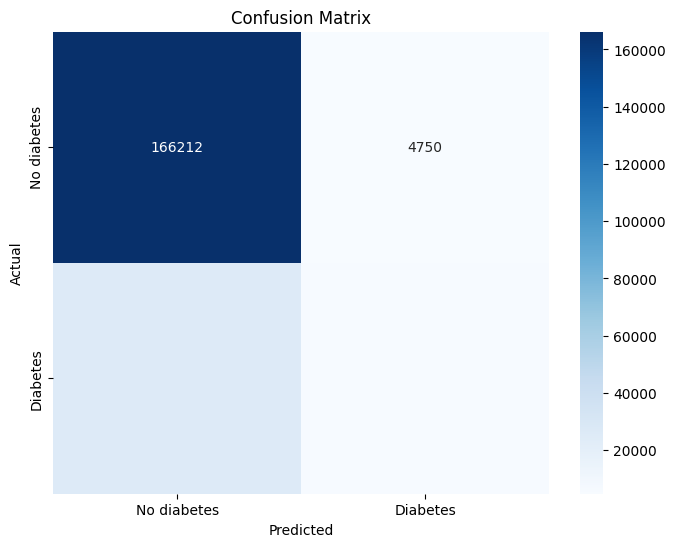

{'C': 93.85537090157501, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.1819249672071006}
MCC: 0.2542839518946986
accuracy: 0.8478595080416272
              precision    recall  f1-score   support

           0       0.86      0.97      0.92    170962
           1       0.55      0.18      0.28     31982

    accuracy                           0.85    202944
   macro avg       0.71      0.58      0.60    202944
weighted avg       0.81      0.85      0.81    202944



In [36]:
# Predicting on the TRAIN data
y_pred_train = model.predict(X_train)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_train, y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
classification_report_output = classification_report(y_train, y_pred_train)

cm = confusion_matrix(y_train, y_pred_train)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No diabetes', 'Diabetes'], yticklabels=['No diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params1)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

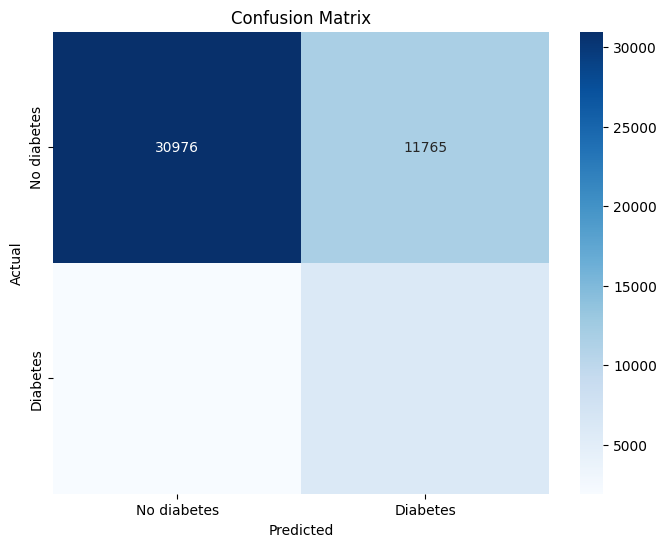

{'C': 93.85537090157501, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.1819249672071006}
MCC: 0.37031666967282556
accuracy: 0.730388678650268
              precision    recall  f1-score   support

           0       0.94      0.72      0.82     42741
           1       0.34      0.76      0.47      7995

    accuracy                           0.73     50736
   macro avg       0.64      0.74      0.64     50736
weighted avg       0.85      0.73      0.76     50736



In [29]:
param_dist = {
    'C': uniform(0.0001, 100),  # Continuous distribution from 0.0001 to 100
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
    'tol': uniform(0.0001, 1),  # tol from 0.0001 to 1
    'max_iter': [10000]
}

random_search = RandomizedSearchCV(
    LogisticRegression(),
    param_distributions=param_dist,
    n_iter=20,  # Try only 20 combinations
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1  # Run in parallel
)

random_search.fit(X_train, y_train)
best_params1 = random_search.best_params_

# Building the Logistic Regression model with the best parameters
model = LogisticRegression(**best_params1, class_weight='balanced')
model.fit(X_train, y_train)

# Predicting on the test data
y_pred = model.predict(X_test)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No diabetes', 'Diabetes'], yticklabels=['No diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params1)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [10]:
pd.DataFrame(y_pred,columns=['LR_y_pred']).to_csv('1.NHL_LR_y_pred.csv')

In [31]:
import statsmodels.api as sm
# **Statistical Analysis with Statsmodels**
# Adding constant for intercept
X_train_const = sm.add_constant(X_train)

# Fit Logistic Regression using statsmodels
logit_model = sm.Logit(y_train, X_train_const,**best_params1)
result = logit_model.fit()

# Coefficients and their statistical significance
print(result.summary())

# Extracting p-values and coefficients
# p_values = result.pvalues
# coefficients = result.params
# print("\nP-Values:\n", p_values)
# print("\nCoefficients:\n", coefficients)

# Diagnostics
print(f"Pseudo R-squared: {result.prsquared}")
print(f"Log-likelihood: {result.llf}")

C:\Users\jiqim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['C', 'max_iter', 'penalty', 'solver', 'tol']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.345965
         Iterations 8


C:\Users\jiqim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['C', 'max_iter', 'penalty', 'solver', 'tol']
  warnings.warn(msg, ValueWarning)


                           Logit Regression Results                           
Dep. Variable:        Diabetes_binary   No. Observations:               202944
Model:                          Logit   Df Residuals:                   202922
Method:                           MLE   Df Model:                           21
Date:                Fri, 25 Jul 2025   Pseudo R-squ.:                  0.2059
Time:                        14:39:03   Log-Likelihood:                -70211.
converged:                       True   LL-Null:                       -88413.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -7.5564      0.097    -78.095      0.000      -7.746      -7.367
HighBP                   0.7071      0.016     45.582      0.000       0.677       0.738
HighChol    

Check overfitting:

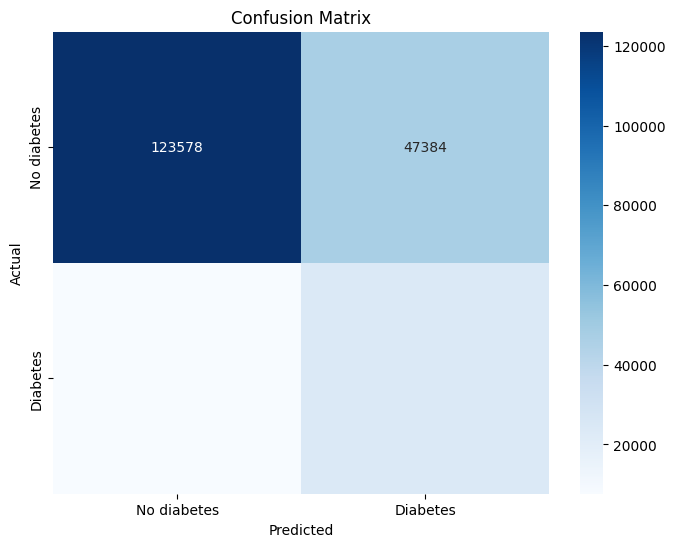

{'C': 93.85537090157501, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.1819249672071006}
MCC: 0.3692543749027478
accuracy: 0.7289547855566068
              precision    recall  f1-score   support

           0       0.94      0.72      0.82    170962
           1       0.34      0.76      0.47     31982

    accuracy                           0.73    202944
   macro avg       0.64      0.74      0.64    202944
weighted avg       0.85      0.73      0.76    202944



In [32]:
# Predicting on the TRAIN data
y_pred_train = model.predict(X_train)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_train, y_pred_train)
accuracy = accuracy_score(y_train, y_pred_train)
classification_report_output = classification_report(y_train, y_pred_train)

cm = confusion_matrix(y_train, y_pred_train)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No diabetes', 'Diabetes'], yticklabels=['No diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params1)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

In [15]:
pd.DataFrame(y_test).to_csv('NHL_y_test.csv')